# Импорт библиотек

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from copy import copy
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_test.shape
#import foolbox
import idx2numpy
#from art.attacks.evasion import DeepFool
#from foolbox.attacks import FGSM

In [2]:
from numpy.random import seed
seed(1)
tf.random.set_seed(2)

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Предобработка данных

In [4]:
x_train = x_train.reshape((60000,28,28,1))
x_train = x_train.astype('float32')/255
x_test = x_test.reshape((10000,28,28,1))
x_test = x_test.astype('float32')/255
x_test.shape

(10000, 28, 28, 1)

In [5]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Собираем нашу модель

In [6]:
model = models.Sequential()
model.add(layers.Conv2D(6, (5, 5),padding='SAME',activation = 'relu',input_shape=(28,28,1),
                        kernel_initializer=keras.initializers.he_normal(seed=42)))
model.add(layers.MaxPooling2D(pool_size=[2, 2], strides=[2, 2],padding='SAME'))
model.add(layers.Conv2D(16,(5,5),activation='relu', kernel_initializer=keras.initializers.he_normal(seed=42)))
model.add(layers.MaxPooling2D(pool_size=[2, 2], strides=[2, 2],padding='SAME'))
model.add(layers.Conv2D(120,(5,5),activation='relu', kernel_initializer=keras.initializers.he_normal(seed=42)))

In [7]:
model.add(layers.Flatten())
model.add(layers.Dense(84,activation='relu', kernel_initializer=keras.initializers.he_normal(seed=42)))
model.add(layers.Dense(10,activation='softmax', kernel_initializer=keras.initializers.glorot_normal(seed=42)))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 6)         156       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 120)         48120     
_________________________________________________________________
flatten (Flatten)            (None, 120)               0         
_________________________________________________________________
dense (Dense)                (None, 84)                1

In [8]:
model.compile(optimizer='adam',
             loss= 'categorical_crossentropy',metrics=['accuracy'])


In [9]:
model.fit(x_train,y_train,epochs=3,batch_size=64)

Epoch 1/3
938/938 [==============================] - 13s 8ms/step - loss: 0.3953 - accuracy: 0.8782
Epoch 2/3
938/938 [==============================] - 4s 4ms/step - loss: 0.0676 - accuracy: 0.9792
Epoch 3/3
938/938 [==============================] - 4s 5ms/step - loss: 0.0440 - accuracy: 0.9865


# Оценим модель на тестовой выборке

In [10]:
test_loss,test_acc=model.evaluate(x_test,y_test)
test_acc

313/313 [==============================] - 3s 9ms/step - loss: 0.0559 - accuracy: 0.9821


0.9821000099182129

In [11]:
# emnist_path = 'C:/Users/kamen/DIPLOM/'
# #X-test - буквы для теста, Y-test - метки букв
# X_test = idx2numpy.convert_from_file(emnist_path + 'emnist-letters-test-images-idx3-ubyte')
# Y_test = idx2numpy.convert_from_file(emnist_path + 'emnist-letters-test-labels-idx1-ubyte')
# X_test = X_test.astype('float32')/255
# X_test = X_test.reshape((20800,28,28,1))
# X_test=X_test[:10000,:,:,:]
# Y_test=to_categorical(Y_test)
# X_test = np.rot90(X_test,1,axes=(-2,-3))
# X_test=X_test[:,:,::-1,:]
# validation_set=np.concatenate([X_test,x_test])

In [12]:
# Predict_set_letters_label = np.zeros(len(validation_set))#Поиск порога отказа
# Predict_set_letters_prob = np.zeros(len(validation_set))
# prediction = model.predict(validation_set)
# for i in range(len(validation_set)):
#     Predict_set_letters_label[i] = np.argmax(prediction[i])
#     Predict_set_letters_prob[i]=np.max(prediction[i])
    

In [13]:
# failure_threshold=tf.reduce_mean(Predict_set_letters_prob,axis=0)
# failure_threshold=tf.reshape(failure_threshold,[]).numpy()

In [14]:
# print(failure_threshold,"Порог отказа")

In [15]:
# def Predict_a_picture(picture_to_predict):
#     array_probability = model.predict(picture_to_predict)
#     probability = np.max(array_probability)
#     label = np.argmax(array_probability)
#     if (probability<failure_threshold):
#         print("This is not a digit")
#     else:
#         print("Это цифра",label,"с вероятностью",probability)
#     return 1
    

In [16]:
# img = x_test[155,:,:,:]
# img=img.reshape((1,28,28,1))
# plt.imshow(img[0,:,:,0])
# Predict_a_picture(img)

# Построение состязательной атаки

In [17]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image):    
    predict_array=model.predict(input_image)
    number_index = np.argmax(predict_array)
    input_image=tf.convert_to_tensor(input_image)
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        print(prediction)
        label = tf.one_hot(number_index,predict_array.shape[-1])
        label = tf.reshape(label, (1, predict_array.shape[-1]))
        loss = loss_object(label, prediction)
    gradient = tape.gradient(loss, input_image)
    signed_grad = tf.sign(gradient)
    signed_grad = signed_grad.numpy()
    #etogo ne bylo
    signed_grad = signed_grad*0.5+0.5
    return signed_grad


# Построение гистограммы вероятностей + изображение под действием состязательной атаки

In [18]:
def build_adv_final(img):
    indices= list(range(0,10))
    attack = create_adversarial_pattern(img)
    for i in range(25):
        data_array = model.predict(np.clip(img+0.01*i*attack,a_max = 1.,a_min = 0.))
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
        axes[0].bar(indices,data_array[0])
        axes[0].set_title('Атака FGSM - методом, eps =%s '%(0.01*(i+1)))
        axes[0].set_xlabel('Метка класса')
        axes[0].set_ylabel('Вероятность')
        axes[0].set_ylim(0,1.0)
        image = np.clip(img[0,:,:,:]+0.01*i*attack[0,:,:,:],a_max = 1.,a_min = 0.)
        image = tf.clip_by_value(image, -1, 1)
        axes[1].imshow(image,cmap="gray")
        plt.show()
        print(np.max(data_array))
    return 1
        

In [19]:

test_pic = x_test[159,:,:,:]
test_pic = test_pic.reshape((1,28,28,1))


tf.Tensor(
[[1.5552390e-06 6.2674703e-04 1.0192792e-05 7.3192047e-07 9.9871528e-01
  2.1523943e-05 1.3101228e-05 7.5300100e-05 6.6848480e-07 5.3490006e-04]], shape=(1, 10), dtype=float32)


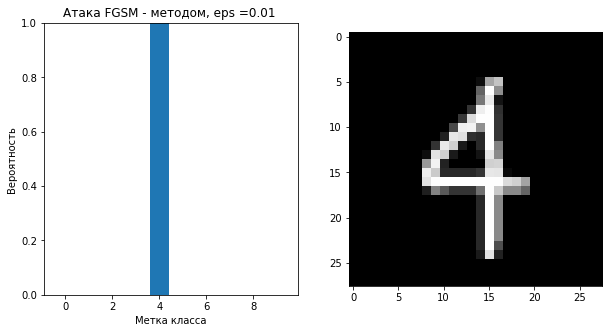

0.9987153


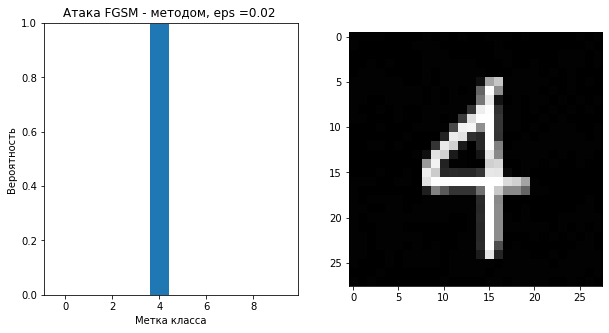

0.99791473


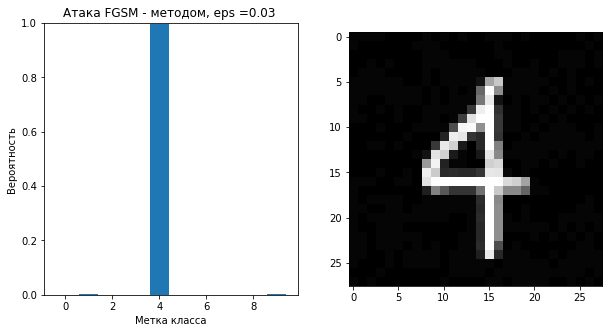

0.996669


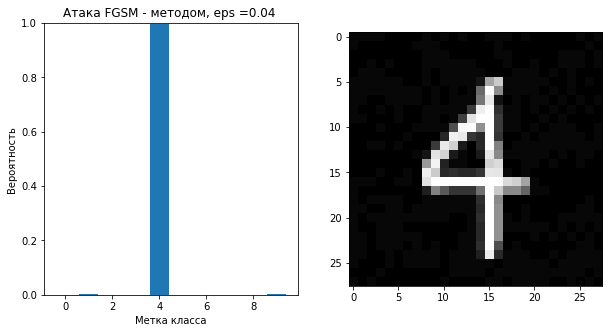

0.99454546


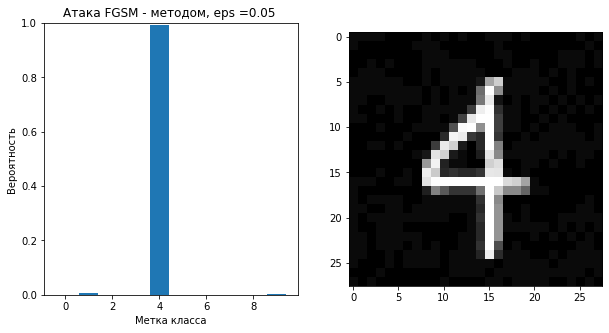

0.9909945


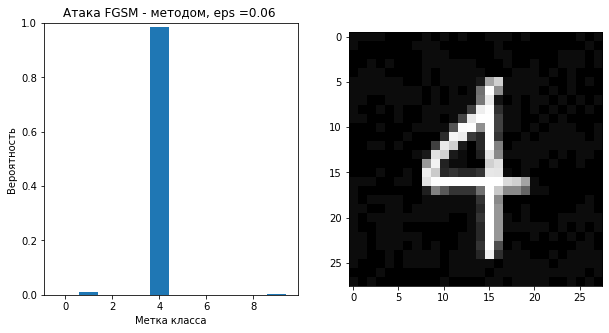

0.98529


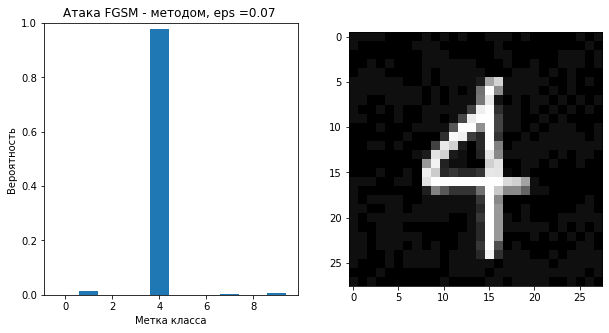

0.9768495


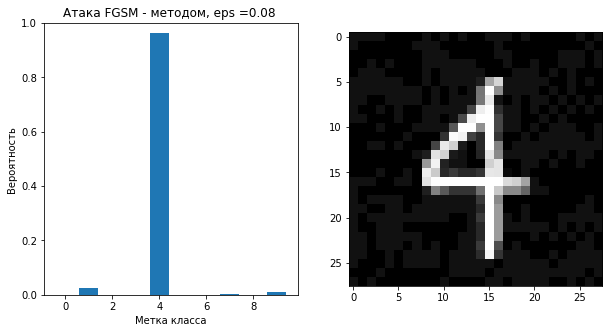

0.9625937


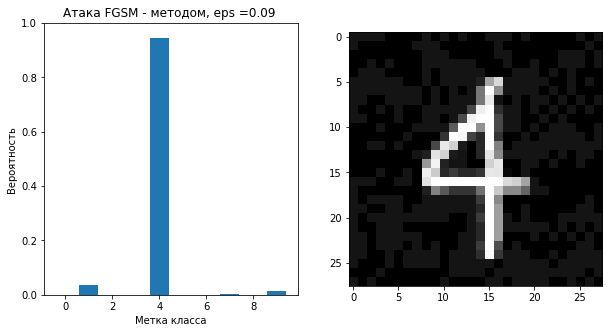

0.94323725


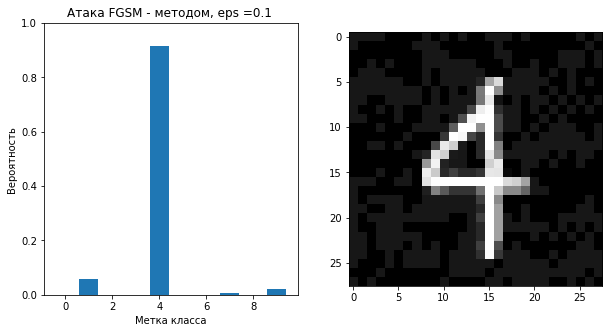

0.9141712


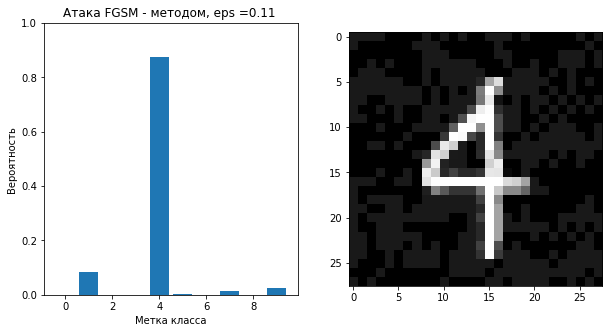

0.8752073


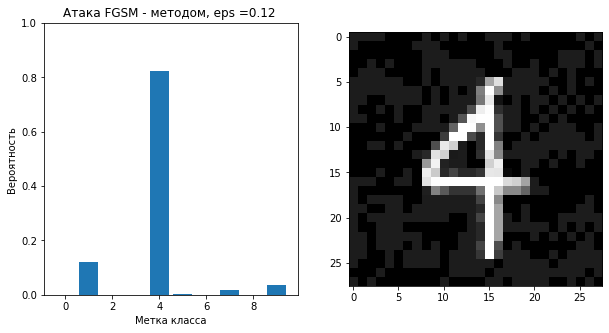

0.8219149


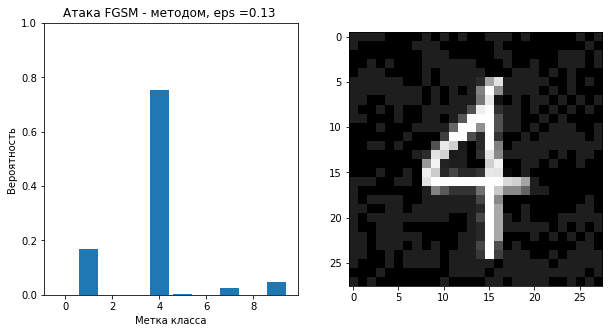

0.7550892


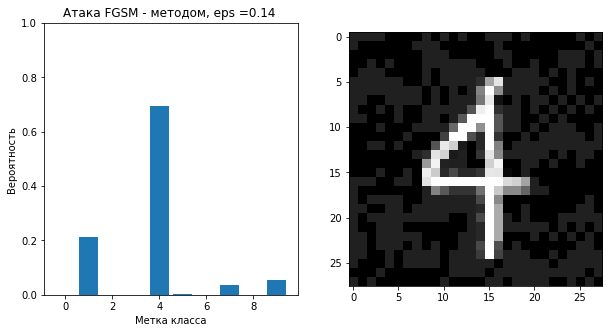

0.69422114


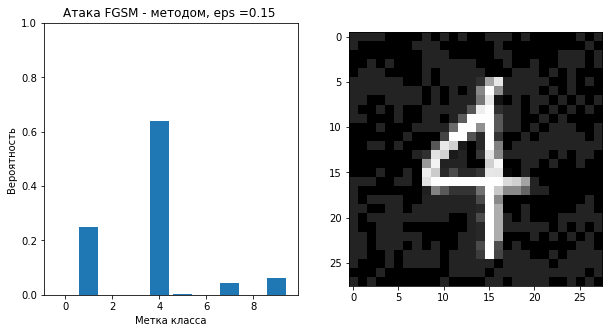

0.63924384


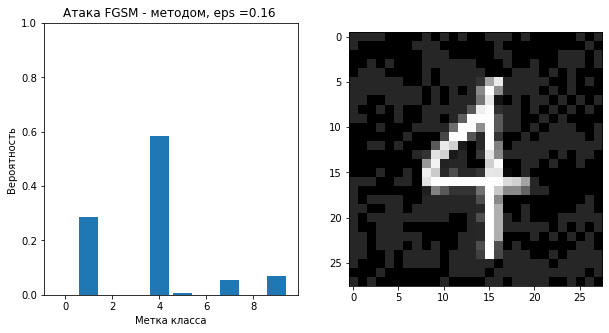

0.582529


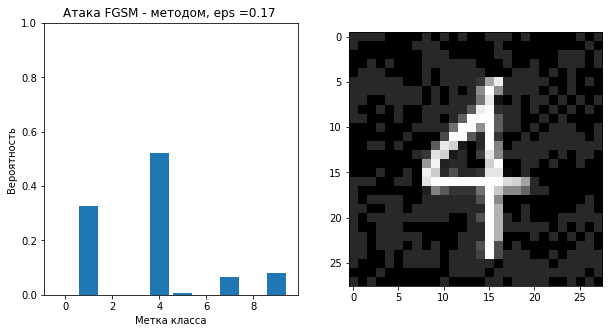

0.5210784


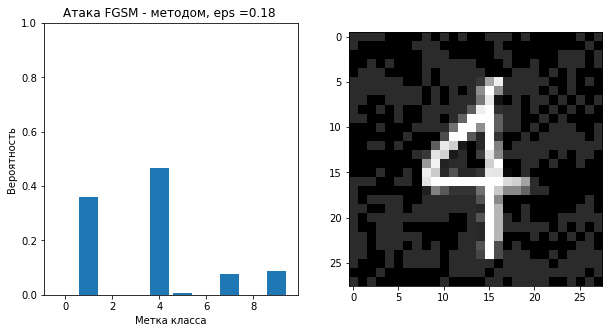

0.46508378


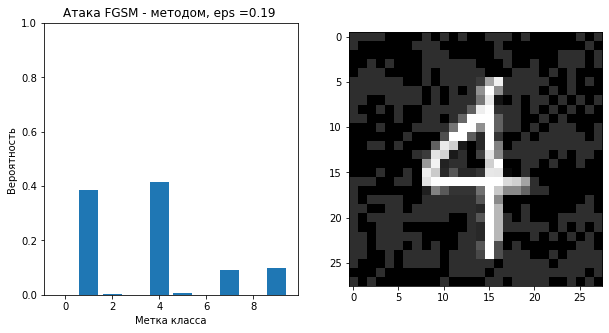

0.41633266


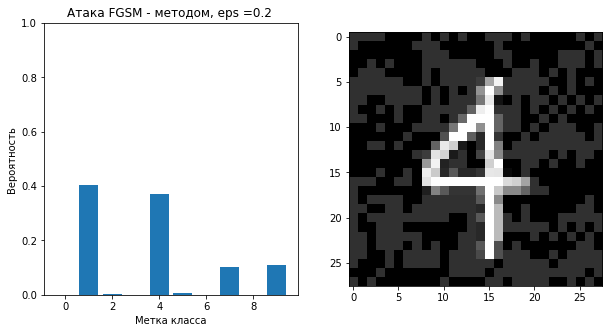

0.40264723


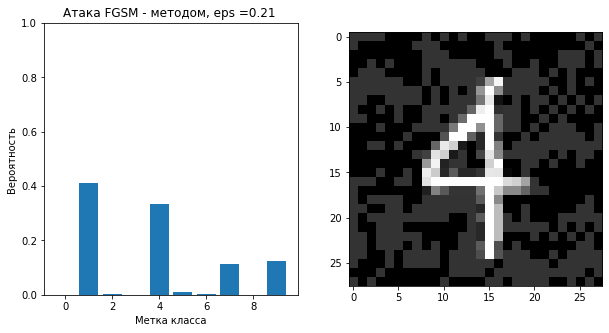

0.41229793


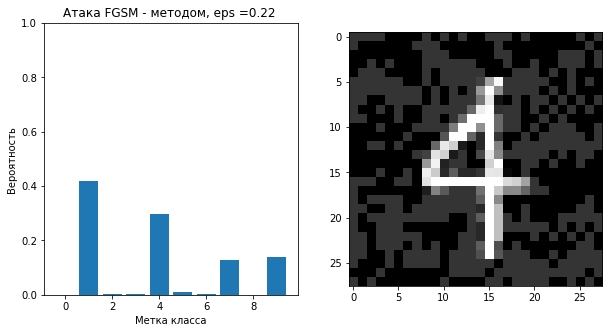

0.41872576


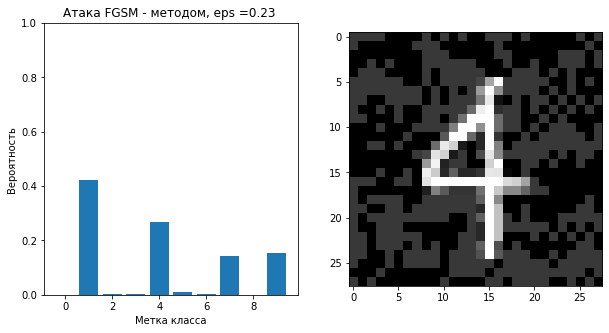

0.42072502


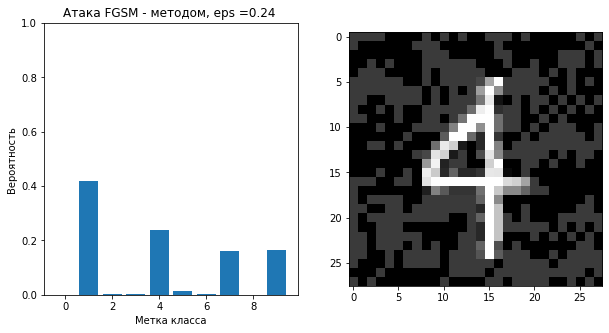

0.41874412


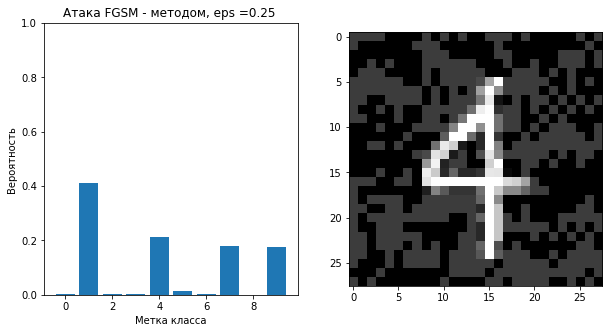

0.4119437


1

In [20]:
build_adv_final(test_pic)

In [21]:
# indices= list(range(0,10))
# adversarial_attack = adversarial_attack_impact
# for i in range(25):
#     attacked_picture,data_array=adversarial_attack_impact(img,(i+1)*0.01)
#     fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
#     axes[0].bar(indices,data_array[0])
#     axes[0].set_title('Атака FGSM - методом, eps =%s '%(0.01*(i+1)))
#     axes[0].set_xlabel('Метка класса')
#     axes[0].set_ylabel('Вероятность')
#     axes[0].set_ylim(0,1.0)
#     axes[1].imshow(attacked_picture[0,:,:,0])
#     plt.show()
    
    


In [22]:
#fig, (ax1, ax2) = plt.subplots(1, 2)
#fig.suptitle('Horizontally stacked subplots')
#ax1.plot(x, y)
#ax2.plot(x, -y)